# <font color='blue'>Programming Assignment: Image Representations</font>

In this problem, we will study how different representations of images can affect the performance of a nearest neighbor classifier.

We will experiment with CIFAR-10 data set, which has 50,000 training images and 10,000 test images, with ten different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The images are in color, of size 32 × 32.

We will investigate the following representions:
1. Raw pixel space
2. Histogram-of-gradients (HOG) features
3. Convolutional Neural Network (CNN) features
    * Intermediate-level and high-level features extracted from a **pretrained** CNN 
    * Intermediate-level and high-level features extracted from a **randomly initialized** CNN 

#### Instructions
1. Install the required libraries
    * Install the CPU version of PyTorch and torchvision
        * A GPU is **not required** for this assigment. 
        * For more specific intructions related to your machine, please refer to: https://pytorch.org/get-started/locally/.
    * Install scikit-learn **1.0.2**
        * Note that in version 1.2.2, KNN classifier with L2 distance behaves weirdly. For example, testing training samples will cause an error. Query results vary a lot over different runs. Classification accurary is close to a random guess. We would recommend using version 1.0.2 instead. 
    * Install scikit-image, numpy, os, matplotlib, tqdm, torchinfo, etc.
        * Use `pip install` to install any other required library.
2. We have provided you with a number of functions and scripts in the hopes of alleviating some tedious or error-prone sections of the implementation. You are free to modify them if necessary. The provided files include:
    * `dataset.py`
        * Functions used to download, load and visualize a dataset
    * `extract_feature.py`
        * Functions to extract a variety of features, including raw pixels, HoG features and CNN features.
    * `vgg_network.py`
        * Class defining the VGG-11 architecture, functions to load a pretrained VGG model and test it. 
    * `path.py`
        * Paths of directories to save the dataset, features, models, and figures. Feel free to reconfigure it.
3. Submission
    * <font color='magenta'><b>This notebook includes various things for you to do.</b></font>

## <font color='blue'>1. Load the data</font>

### Download the data set
We will be using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set for our experiments. Before getting started, run the following block to download the data set. The data set will be saved to directory `/datasets`. You can change the default download path in `path.py`.

In [1]:
from dataset import download_cifar10_dataset
dataset = download_cifar10_dataset()

Dataset Downloading ...


### Load in the data set

Run the following block to load the training images, training labels, test images, and test labels as `x_train`, `y_train`, `x_test`, `y_test` respectively. The code will print out their shapes for you.

In [2]:
from dataset import load_dataset_splits
x_train, y_train, x_test, y_test = load_dataset_splits()

======> CIFAR-10 dataset loaded
Training set data shape:  (50000, 3, 32, 32)
Training set label shape:  (50000,)
Test set data shape:  (10000, 3, 32, 32)
Test set label shape:  (10000,)


### Visualize the data
Run the following block to display several randomly-sampled images from each of the ten classes.

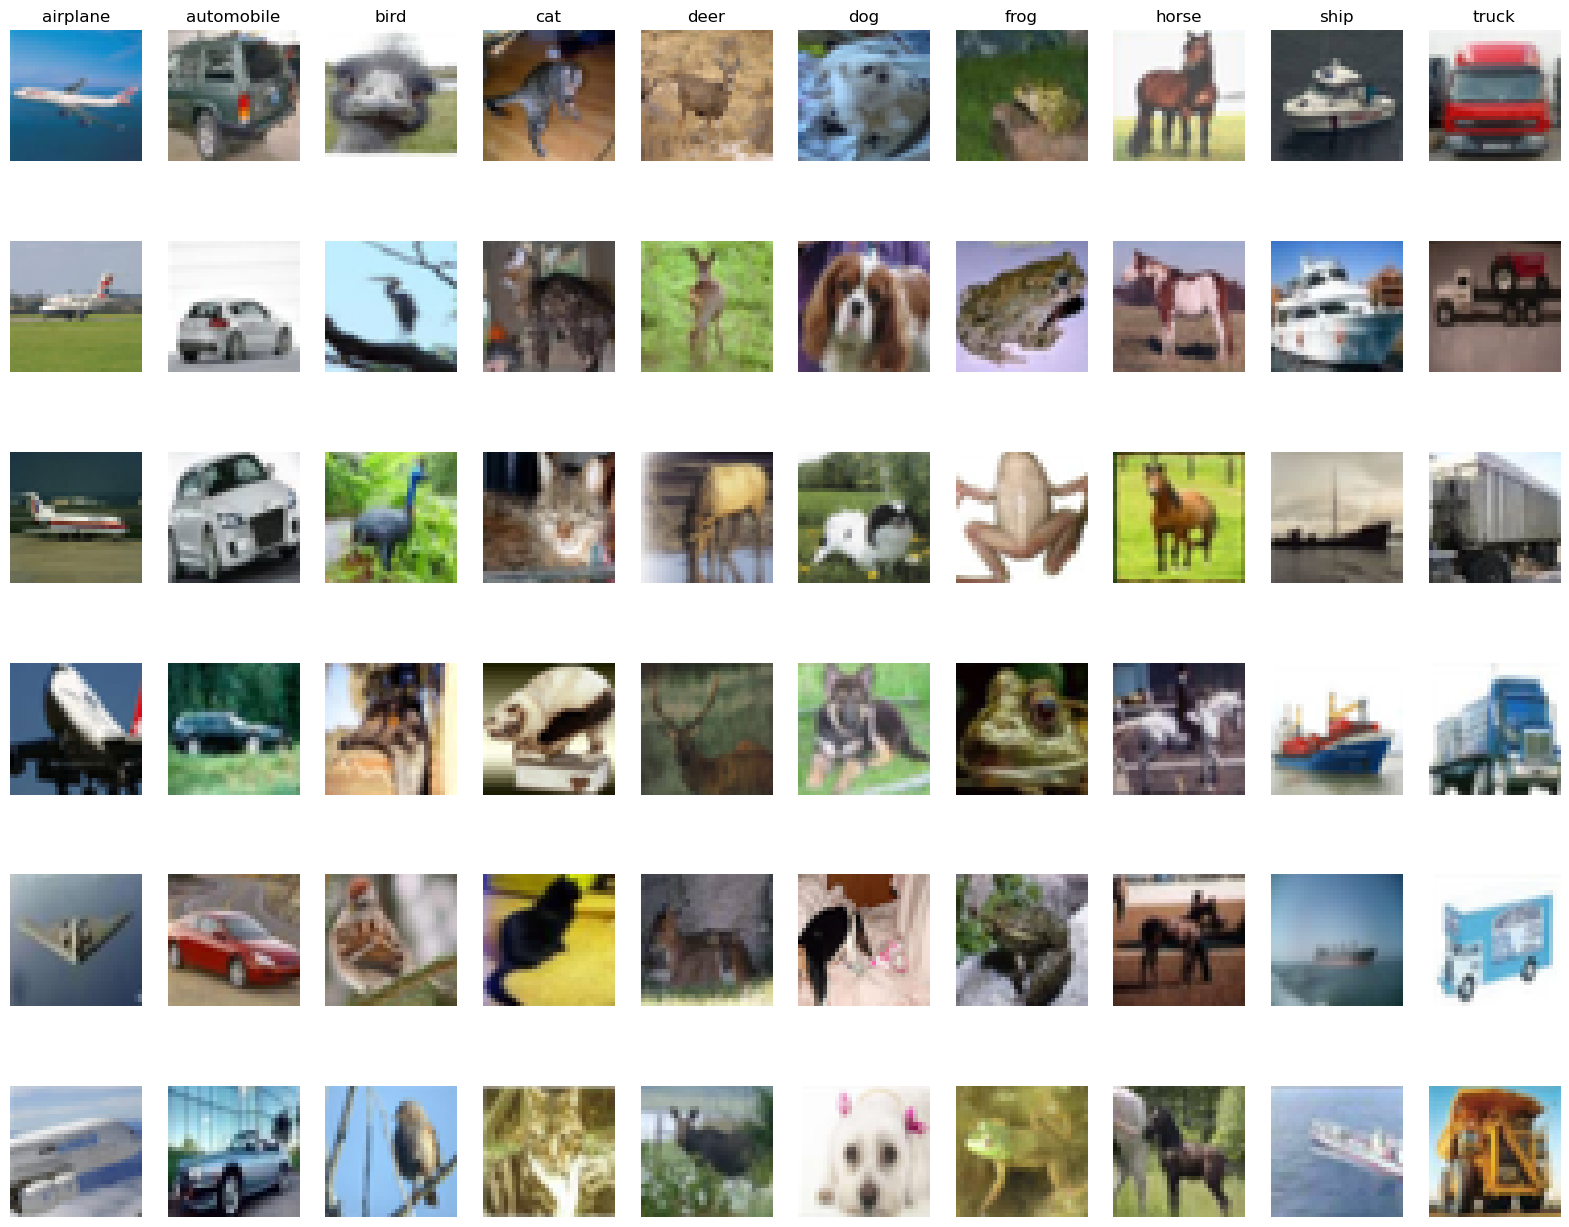

In [3]:
from dataset import visualize_cifar_data
visualize_cifar_data(images=x_train.transpose(0, 2, 3, 1), labels=y_train, samples_per_class=6)

## <font color='blue'>2. Nearest neighbor classification on CIFAR-10</font>

In this part, we will investigate the classification problem by training and testing a nearest neighbor classifier on CIFAR-10 dataset with **Euclidean (L2) distance**. 

Function `run_nearest_neighbor`, shown in the next cell, takes a labeled training set (`x_train`, `y_train`) and test set (`x_test`, `y_test`), and applies 1-nearest neighbor classification to the test points, using `KNeighborsClassifier` from `sklearn`. It prints out the accuracy on the test set and returns the classifier.


In [3]:
from sklearn.neighbors import KNeighborsClassifier

def run_nearest_neighbor(x_train, y_train, x_test, y_test):
    # create classifier
    nn_classifier = KNeighborsClassifier(n_neighbors=1, algorithm='auto')
    
    # train 
    nn_classifier.fit(x_train, y_train)

    # test and report accuracy
    test_acc = nn_classifier.score(x_test, y_test)
    print("Nearest neighbor accuracy on the test set: %f"%test_acc)
    
    return nn_classifier

### Nearest neighbor on raw pixels

Now we do nearest neighbor classification in the raw pixel space. 

We have provided you with a function `compute_or_load_features` in `extract_feature.py` to extract the features from the training and test images. You can specify the feature extraction method by setting parameter `feature_type` to one of the options in `['raw_pixel', 'hog', 'pretrained_cnn', 'random_cnn']`. When the features are extracted by a CNN, you can further specify at which layer you are extracting the features by setting parameter `layer` to one of the options in `['last_conv', 'last_fc']`. In practice, extracting features from a large data set could be time consuming. To avoid repeated computation, this function will only compute the features once and store them in directory `/features` (you can change this in `path.py`). If being called later, the function will search for the existing feature files and directly load them into memory. 

Call function `compute_or_load_features` to extract the raw pixels as features and call function `run_knn` to train and test nearest neighbor classifier in this feature space. <font color='magenta'>To do: Report the test accuracy you get.</font>

In [4]:
from extract_feature import compute_or_load_features

# compute or load features
raw_pixel_train_features, raw_pixel_test_features = compute_or_load_features(x_train, x_test, "raw_pixel")

# run knn
raw_pixel_knn_classifier = run_nearest_neighbor(raw_pixel_train_features, y_train, raw_pixel_test_features, y_test)

======> Loaded train and test features from  c:\Users\Jeremiah\Desktop\Research Project Dasgupta\Workspace\features\raw_pixel.pkl
Training feature shape:  (50000, 3072)
Test feature shape:  (10000, 3072)
Nearest neighbor accuracy on the test set: 0.353900


To get a sense of how the images are distributed locally in the pixel space, we can look at their nearest neighbors. 

<font color='magenta'>To do: Write code in the following block to do the following. Make your code modular so that it can be re-used for the representations we will consider.</font>
* <font color='magenta'>Show the first five images in the test set whose label is correctly predicted by 1-NN, and show the nearest neighbor (in the training set) of each of these images.</font>
* <font color='magenta'>Show the first five images in the test set whose label is incorrectly predicted by 1-NN, and show the nearest neighbor (in the training set) of each of the images.</font>


In [16]:
### Your code here

from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

def find_nearest_neighbors(nn_classifier, features_test, labels_test, k=1):

    # Predict labels for the test set
    predicted_labels = nn_classifier.predict(features_test)

    # Find indices of correctly and incorrectly predicted samples
    correct_indices = np.where(predicted_labels == labels_test)[0]
    incorrect_indices = np.where(predicted_labels != labels_test)[0]

    # Find nearest neighbors for correctly predicted samples
    correct_nearest_neighbors = nn_classifier.kneighbors(features_test[correct_indices], n_neighbors=k, return_distance=False)

    # Find nearest neighbors for incorrectly predicted samples
    incorrect_nearest_neighbors = nn_classifier.kneighbors(features_test[incorrect_indices], n_neighbors=k, return_distance=False)

    return correct_indices, correct_nearest_neighbors, incorrect_indices, incorrect_nearest_neighbors

# Assuming raw_pixel_train_features, raw_pixel_test_features, y_train, y_test are available
correct_indices, correct_nearest_neighbors, incorrect_indices, incorrect_nearest_neighbors = find_nearest_neighbors(raw_pixel_knn_classifier, raw_pixel_test_features, y_test)

print(correct_indices)
print(correct_nearest_neighbors)
print(incorrect_indices)
print(incorrect_nearest_neighbors)




[   1    2    3 ... 9986 9988 9997]
[[42768]
 [21298]
 [37867]
 ...
 [11529]
 [32234]
 [13252]]
[   0    4    6 ... 9996 9998 9999]
[[47188]
 [ 1881]
 [38805]
 ...
 [32277]
 [17939]
 [29496]]


In [29]:
print(x_train[0].shape)

print(x_test[incorrect_indices[:5]].shape)
print(x_train[0].shape)

(3, 32, 32)
(5, 3, 32, 32)
(3, 32, 32)


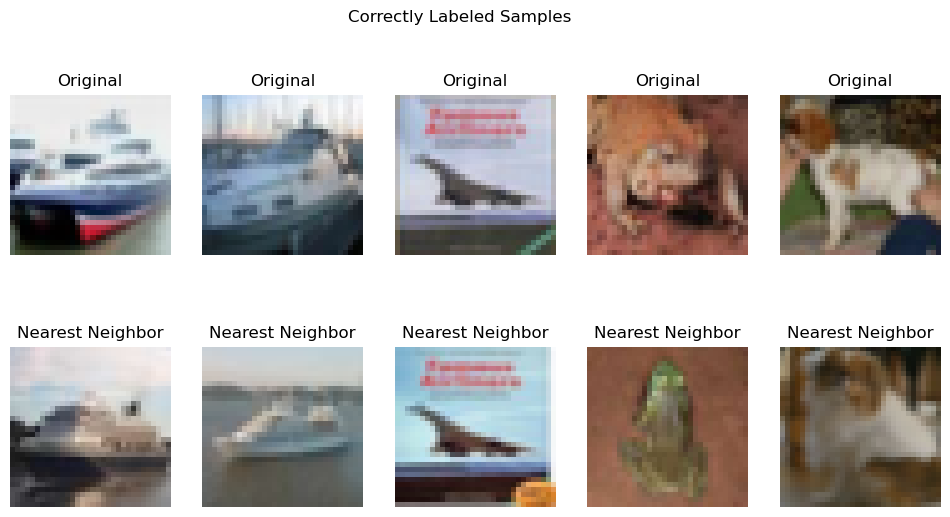

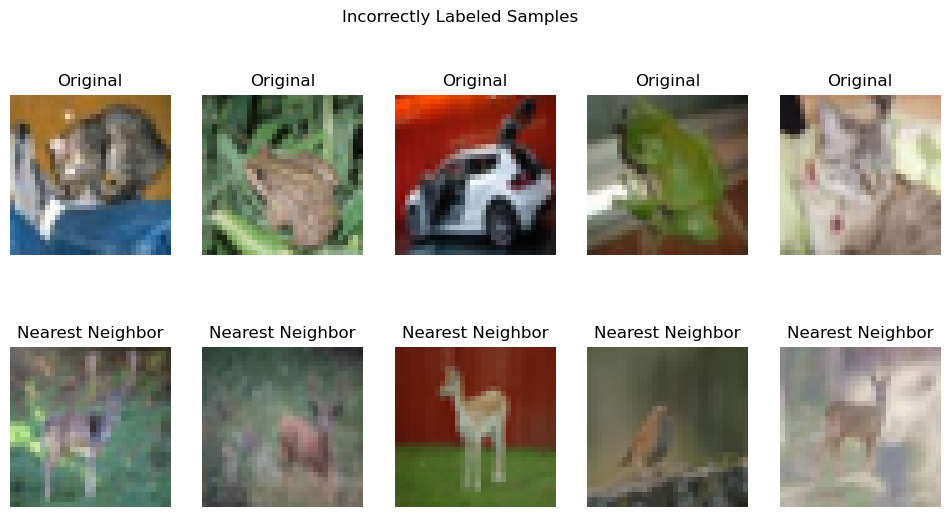

In [33]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def show_nearest_neighbors(images, nearest_neighbors, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    for i in range(len(images)):
        plt.subplot(2, len(images), i + 1)
        current_image = images[i].transpose((1, 2, 0))  # Move channels to the last dimension
        plt.imshow(current_image)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, len(images), len(images) + i + 1)
        nearest_image_index = nearest_neighbors[i]
        nearest_image = np.squeeze(x_train[nearest_image_index], axis=0).transpose((1, 2, 0))

        # Ensure the nearest image has the same data type as the current image
        nearest_image = nearest_image.astype(current_image.dtype)

        plt.imshow(nearest_image)
        plt.title("Nearest Neighbor")
        plt.axis('off')

    plt.show()


# Show the first five correctly labeled images and their nearest neighbors
show_nearest_neighbors(x_test[correct_indices[:5]],
                        correct_nearest_neighbors,
                        "Correctly Labeled Samples")

# Show the first five incorrectly labeled images and their nearest neighbors
show_nearest_neighbors(x_test[incorrect_indices[:5]],
                        incorrect_nearest_neighbors,
                        "Incorrectly Labeled Samples")



### Nearest neighbor on HOG features 
The HOG (Histogram of Oriented Gradients) descriptor computes local statistics of gradients in an image and uses them as feature respresentations. Train and test a nearest neighbor classifier on HOG features. <font color='magenta'>To do: Report the test accuracy. As with the raw pixel representation, show the first five correctly classified images (and their nearest neighbors) and the five first incorrectly classified.</font>

In [6]:
from extract_feature import compute_or_load_features

# compute or load features
hog_train_features, hog_test_features = compute_or_load_features(x_train, x_test, "hog")
    
# run knn
hog_knn_classifier = run_nearest_neighbor(hog_train_features, y_train, hog_test_features, y_test)

100%|██████████| 10000/10000 [00:14<00:00, 692.99it/s]


======> Done with computation of HoG features
======> Saved train and test features to  c:\Users\Jeremiah\Desktop\Research Project Dasgupta\Workspace\features\hog.pkl
Training feature shape:  (50000, 512)
Test feature shape:  (10000, 512)
Nearest neighbor accuracy on the test set: 0.365700


### Nearest neighbor on CNN features

Over the past decade, deep <em>convolutional neural networks</em> (CNNs) have become building blocks in a wide range of computer vision tasks. A CNN trained on a large scale image classification task learns to extract spatial hierarchies of features from edges to object parts [2].  

In this problem, we will explore the representations learned by CNNs on different layers. We will be using [VGG](https://arxiv.org/abs/1409.1556) as our convolutional network architecture. A VGG11 model pretrained on CIFAR-10 can be found at `/models/vgg11_bn.pt`, so you are **NOT REQUIRED** to train the neural network. And since we only need to do forward pass through the network (no backpropagation), a CPU is enough for our purpose.

A VGG network is composed of a sequence of convolutional layers, pooling layers, and fully connected layers. To clearly understand its architecture, we provide you with a helper function visualizing the layers and input/output shapes. The following code feeds a batch of 32 × 32 × 3 images into VGG11 network and do a forward pass. Run the code and check the summary. 

In [7]:
from torchinfo import summary
from vgg_network import vgg11_bn

vgg_model = vgg11_bn(pretrained=False)
summary(vgg_model, input_size=(16, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [16, 10]                  --
├─Sequential: 1-1                        [16, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [16, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [16, 64, 32, 32]          128
│    └─ReLU: 2-3                         [16, 64, 32, 32]          --
│    └─MaxPool2d: 2-4                    [16, 64, 16, 16]          --
│    └─Conv2d: 2-5                       [16, 128, 16, 16]         73,856
│    └─BatchNorm2d: 2-6                  [16, 128, 16, 16]         256
│    └─ReLU: 2-7                         [16, 128, 16, 16]         --
│    └─MaxPool2d: 2-8                    [16, 128, 8, 8]           --
│    └─Conv2d: 2-9                       [16, 256, 8, 8]           295,168
│    └─BatchNorm2d: 2-10                 [16, 256, 8, 8]           512
│    └─ReLU: 2-11                        [16, 256, 8, 8]           --


### Nearest neighbor on pretrained CNN features

As shown in the summary above, a VGG net consists of three components: 
1. A sequence of convolutional blocks (1-1 and 1-2)
2. Two fully connected blocks (2-30 to 2-35)
3. A single fully connected layer (2-36)

The first two components together act as a feature extractor. The convolutional blocks extract the low-level and intermediate-level features, and the fully connected blocks extract the high-level features. The third component is a single linear layer mapping the feature vectors to the classes therefore can be viewed as a linear classifier. 

In this problem, we will experiment with features extracted by a pretrained VGG net at two specific layers:
1. `last_conv`: AdaptiveAvgPool2d (1-2)
2. `last_fc`: ReLU (2-34)

Train and test a nearest neighbor classifier on pretrained VGG features at these two layers respectively (Set parameter `layer` of function `compute_or_load_features` to `last_conv` or `last_fc`). <font color='magenta'>Report the test accuracies with these two representations. For `last_fc`, show the first five correctly classified images (with nearest neighbors) and the first five incorrectly classified.</font>

In [ ]:
from extract_feature import compute_or_load_features

# compute or load features
pretrained_cnn_last_conv_train_features, pretrained_cnn_last_conv_test_features = compute_or_load_features(x_train, x_test, "pretrained_cnn", "last_conv")

# run knn
pretrained_cnn_last_conv_knn_classifier = run_nearest_neighbor(pretrained_cnn_last_conv_train_features, y_train, pretrained_cnn_last_conv_test_features, y_test)

In [ ]:
from extract_feature import compute_or_load_features

# compute or load features
pretrained_cnn_last_fc_train_features, pretrained_cnn_last_fc_test_features = compute_or_load_features(x_train, x_test, "pretrained_cnn", "last_fc")

# run knn
pretrained_cnn_last_fc_knn_classifier = run_nearest_neighbor(pretrained_cnn_last_fc_train_features, y_train, pretrained_cnn_last_fc_test_features, y_test)

### Alignment between nearest neighbor classifier and pretrained CNN model
In the following block, call function `test_pretrained_vgg` from `vgg_network.py`. The function will test the pretrained VGG net on the test images of CIFAR-10 and return the test accuracy. Report this accuracy and compare it with the test accuracy of nearest neighbor classifier in pretrained `last conv` and `last fc` feature space. In which space does the nearest neighbor classifier behave the most similarly to a pretrained CNN model?

In [ ]:
from vgg_network import test_pretrained_vgg

test_acc = test_pretrained_vgg(x_test, y_test)
print('Accuracy on the test images: ', test_acc) 

### Nearest neighbor on random CNN features

The excellent feature extraction ability of ConvNets enables them to solve computer vision problems in a universal way. One may think that this is because ConvNets are generally trained on large datasets of images. But is this the only reason?  To answer this question, a recent work Deep Image Prior [1] shows that the structure of a CNN is sufficient to capture a great deal of low-level image statistics prior to any learning. A randomly initialized fully-convolutional neural network is already able to achieve good results in standard image reconstruction problems such as denoising, super-resolution, and inpainting. 

In this problem, we will investigate whether the inductive bias captured by the ConvNets also helps for image classification problems.

You will train and test the nearest neighbor classifier on the features extracted by a randomly initialized VGG network. <font color='magenta'>To do: Experiment with two feature spaces `last conv` and `last fc`, and report the test accuracies.</font>  

In [ ]:
from extract_feature import compute_or_load_features

# compute or load features
random_cnn_last_conv_train_features, random_cnn_last_conv_test_features = compute_or_load_features(x_train, x_test, "random_cnn", "last_conv")

# run knn
random_cnn_last_conv_knn_classifier = run_nearest_neighbor(random_cnn_last_conv_train_features, y_train, random_cnn_last_conv_test_features, y_test)

In [ ]:
from extract_feature import compute_or_load_features

# compute or load features
random_cnn_last_fc_train_features, random_cnn_last_fc_test_features = compute_or_load_features(x_train, x_test, "random_cnn", "last_fc")

# run knn
random_cnn_last_fc_knn_classifier = run_nearest_neighbor(random_cnn_last_fc_train_features, y_train, random_cnn_last_fc_test_features, y_test)

Compare the test accuracies of nearest neighbor classifier on random `last conv` features and HOG features. In which representation space does it perform better?

Compare the test accuracies of nearest neighbor classifier on random `last conv` features and random `last fc` features. In which representation space does it perform better?

## References
1. D. Ulyanov, A. Vedaldi, and V. Lempitsky, [Deep Image Prior](https://arxiv.org/pdf/1711.10925.pdf), CVPR 2018.
2. M. Zeiler and R. Fergus, [Visualizing and Understanding Deep Neural Networks](https://arxiv.org/pdf/1311.2901.pdf), ECCV 2014.  